In [ ]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [ ]:
#|default_exp agents.trpo

In [ ]:
#|export
# Python native modules
from typing import *
from typing_extensions import Literal
import typing 
# Third party libs
import numpy as np
import torch
from torch import nn
from torch.distributions import *
import torchdata.datapipes as dp 
from torchdata.dataloader2.graph import DataPipe,traverse,replace_dp
from fastcore.all import test_eq,test_ne
# Local modules
from fastrl.core import *
from fastrl.pipes.core import *
from fastrl.torch_core import *
from fastrl.layers import *
from fastrl.data.block import *
from fastrl.envs.gym import *

# TRPO
> Trust Region Policy Optimization via online-learning for continuous action domains

[(Schulman et al., 2015) [TRPO] Trust Region Policy Optimization](https://arxiv.org/abs/1502.05477).

Directly based on [`ikostrikov`'s implimentation](https://github.com/ikostrikov/pytorch-trpo) and
coda / explainations in [Shewchuk Cs.Cmu.Edu, 2022, Accessed 19 Nov 2022.](cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf)

## Core

In [ ]:
#|export
class AdvantageStep(typing.NamedTuple):
    state:       torch.FloatTensor=torch.FloatTensor([0])
    action:      torch.FloatTensor=torch.FloatTensor([0])
    next_state:  torch.FloatTensor=torch.FloatTensor([0])
    terminated:  torch.BoolTensor=torch.BoolTensor([1])
    truncated:   torch.BoolTensor=torch.BoolTensor([1])
    reward:      torch.FloatTensor=torch.LongTensor([0])
    total_reward:torch.FloatTensor=torch.FloatTensor([0])
    advantage:   torch.FloatTensor=torch.FloatTensor([0])
    env_id:      torch.LongTensor=torch.LongTensor([0])
    proc_id:     torch.LongTensor=torch.LongTensor([0])
    step_n:      torch.LongTensor=torch.LongTensor([0])
    episode_n:   torch.LongTensor=torch.LongTensor([0])
    image:       torch.FloatTensor=torch.FloatTensor([0])
    
    def clone(self):
        return self.__class__(
            **{fld:getattr(self,fld).clone() for fld in self.__class__._fields}
        )
    
    def detach(self):
        return self.__class__(
            **{fld:getattr(self,fld).detach() for fld in self.__class__._fields}
        )
    
    def device(self,device='cpu'):
        return self.__class__(
            **{fld:getattr(self,fld).to(device=device) for fld in self.__class__._fields}
        )

    def to(self,*args,**kwargs):
        return self.__class__(
            **{fld:getattr(self,fld).to(*args,**kwargs) for fld in self.__class__._fields}
        )
    
    @classmethod
    def random(cls,seed=None,**flds):
        _flds,_annos = cls._fields,cls.__annotations__

        def _random_annos(anno):
            t = anno(1)
            if anno==torch.BoolTensor: t.random_(2) 
            else:                      t.random_(100)
            return t

        return cls(
            *(flds.get(
                f,_random_annos(_annos[f])
            ) for f in _flds)
        )

add_namedtuple_doc(
AdvantageStep,
"""Represents a single step in an environment similar to `SimpleStep` however has
an addition field called `advantage`.""",
advantage="""Generally characterized as $A(s,a) = Q(s,a) - V(s)$""",
**{f:getattr(SimpleStep,f).__doc__ for f in SimpleStep._fields}
)

In [ ]:
show_doc(AdvantageStep)

---

### AdvantageStep

>      AdvantageStep (state:torch.FloatTensor=tensor([0.]),
>                     action:torch.FloatTensor=tensor([0.]),
>                     next_state:torch.FloatTensor=tensor([0.]),
>                     terminated:torch.BoolTensor=tensor([True]),
>                     truncated:torch.BoolTensor=tensor([True]),
>                     reward:torch.FloatTensor=tensor([0]),
>                     total_reward:torch.FloatTensor=tensor([0.]),
>                     advantage:torch.FloatTensor=tensor([0.]),
>                     env_id:torch.LongTensor=tensor([0]),
>                     proc_id:torch.LongTensor=tensor([0]),
>                     step_n:torch.LongTensor=tensor([0]),
>                     episode_n:torch.LongTensor=tensor([0]),
>                     image:torch.FloatTensor=tensor([0.]))

Represents a single step in an environment similar to `SimpleStep` however has
an addition field called `advantage`.

Parameters:

 - **state**:`<class 'torch.FloatTensor'>`  = `tensor([0.])`Both the initial state of the environment and the previous state.
 - **action**:`<class 'torch.FloatTensor'>`  = `tensor([0.])`The action that was taken to transition from `state` to `next_state`
 - **next_state**:`<class 'torch.FloatTensor'>`  = `tensor([0.])`Both the next state, and the last state in the environment
 - **terminated**:`<class 'torch.BoolTensor'>`  = `tensor([True])`Represents an ending condition for an environment such as reaching a goal or 'living long enough' as 
                    described by the MDP.
                    Good reference is: https://github.com/openai/gym/blob/39b8661cb09f19cb8c8d2f59b57417517de89cb0/gym/core.py#L151-L155
 - **truncated**:`<class 'torch.BoolTensor'>`  = `tensor([True])`Represents an ending condition for an environment that can be seen as an out of bounds condition either
                   literally going out of bounds, breaking rules, or exceeding the timelimit allowed by the MDP.
                   Good reference is: https://github.com/openai/gym/blob/39b8661cb09f19cb8c8d2f59b57417517de89cb0/gym/core.py#L151-L155'
 - **reward**:`<class 'torch.FloatTensor'>`  = `tensor([0])`The single reward for this step.
 - **total_reward**:`<class 'torch.FloatTensor'>`  = `tensor([0.])`The total accumulated reward for this episode up to this step.
 - **advantage**:`<class 'torch.FloatTensor'>`  = `tensor([0.])`Generally characterized as $A(s,a) = Q(s,a) - V(s)$
 - **env_id**:`<class 'torch.LongTensor'>`  = `tensor([0])`The environment this step came from (useful for debugging)
 - **proc_id**:`<class 'torch.LongTensor'>`  = `tensor([0])`The process this step came from (useful for debugging)
 - **step_n**:`<class 'torch.LongTensor'>`  = `tensor([0])`The step number in a given episode.
 - **episode_n**:`<class 'torch.LongTensor'>`  = `tensor([0])`The episode this environment is currently running through.
 - **image**:`<class 'torch.FloatTensor'>`  = `tensor([0.])`Intended for display and logging only. If the intention is to use images for training an
               agent, then use a env wrapper instead.

## Memory
> Policy gradient online models use short term trajectory samples instead of
ER / iid memory

In [ ]:
#|export
def pipe2device(pipe,device,debug=False):
    "Attempt to move an entire `pipe` and its pipeline to `device`"
    pipes = find_dps(traverse(pipe),dp.iter.IterDataPipe,include_subclasses=True)
    for pipe in pipes:
        if hasattr(pipe,'to'): 
            if debug: print(f'Moving {pipe} to {device}')
            pipe.to(device=device)

In [ ]:
#|export
@torch.jit.script
def discounted_cumsum_(t:torch.Tensor,gamma:float,reverse:bool=False):
    """Performs a cumulative sum on `t` where `gamma` is applied for each index
    >1."""
    if reverse:
        # We do +2 because +1 is needed to avoid out of index t[idx], and +2 is needed
        # to avoid out of index for t[idx+1].
        for idx in range(t.size(0)-2,-1,-1):
            t[idx] = t[idx] + t[idx+1] * gamma
    else:
        for idx in range(1,t.size(0)):
            t[idx] = t[idx] + t[idx-1] * gamma

In [ ]:
#|export
def get_flat_params_from(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))

    flat_params = torch.cat(params)
    return flat_params


def set_flat_params_to(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(
            flat_params[prev_ind:prev_ind + flat_size].view(param.size()))
        prev_ind += flat_size

In [ ]:
#|hide
# https://discuss.pytorch.org/t/how-to-measure-time-in-pytorch/26964/2
# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     discounted_cumsum(torch.ones(500),0.99)
# print(prof)

In [ ]:
#|export
class AdvantageBuffer(dp.iter.IterDataPipe):
    debug=False
    def __init__(self,
            # A datapipe that produces `StepType`s.
            source_datapipe:DataPipe,
            # A model that takes in a `state` and outputs a single value 
            # representing $V$, where as $Q$ is $V + reward$
            critic:nn.Module,
            # Will accumulate up to `bs` or when the episode has terminated.
            bs=1000,
            # The discount factor, otherwise known as $\gamma$, is defined in 
            # (Shulman et al., 2016) as '... $\gamma$ introduces bias into
            # the policy gradient estimate...'.
            discount:float=0.99,
            # $\lambda$ is unqiue to GAE and manages importance to values when 
            # they are in accurate is defined in (Shulman et al., 2016) as '... $\lambda$ < 1
            # introduces bias only when the value function is inaccurate....'.
            gamma:float=0.99
        ):
        self.source_datapipe = source_datapipe
        self.bs = bs
        self.critic = critic
        self.device = None
        self.discount = discount
        self.gamma = gamma
        self.env_advantage_buffer:Dict[Literal['env'],list] = {}

    def to(self,*args,**kwargs):
        self.device = kwargs.get('device',None)

    def __repr__(self):
        return str({k:v if k!='env_advantage_buffer' else f'{len(self)} elements' 
                    for k,v in self.__dict__.items()})

    def __len__(self): return self._sz_tracker

    def update_advantage_buffer(self,step:StepType) -> int:
        if self.debug: 
            print('Adding to advantage buffer: ',step)
        env_id = int(step.env_id.detach().cpu())
        if env_id not in self.env_advantage_buffer: 
            self.env_advantage_buffer[env_id] = []
        self.env_advantage_buffer[env_id].append(step)
        return env_id
        
    def zip_steps(
            self,
            steps:List[StepType]
        ) -> Tuple[torch.FloatTensor,torch.FloatTensor,torch.BoolTensor]:
            step_subset = [(o.reward,o.state,o.truncated or o.terminated) for o in steps]
            zipped_fields = zip(*step_subset)
            return L(zipped_fields).map(torch.vstack)

    def delta_calc(self,reward,v,v_next,done):
        return reward + (self.gamma * v * done) - v_next

    def __iter__(self) -> AdvantageStep:
        self.env_advantage_buffer:Dict[Literal['env'],list] = {}
        for step in self.source_datapipe:
            env_id = self.update_advantage_buffer(step)
            done = step.truncated or step.terminated
            if done or len(self.env_advantage_buffer[env_id])>self.bs:
                steps = self.env_advantage_buffer[env_id]
                rewards,states,dones = self.zip_steps(steps)
                # We vstack the final next_state so we have a complete picture
                # of the state transitions and matching reward/done shapes.
                values = self.critic(torch.vstack((states,steps[-1].next_state)))
                delta = self.delta_calc(rewards,values[:-1],values[1:],dones)
                discounted_cumsum_(delta,self.discount*self.gamma,reverse=True)

                for _step,gae_advantage in zip(*(steps,delta)):
                    yield AdvantageStep(
                        advantage=gae_advantage,
                        **{f:getattr(_step,f) for f in _step._fields}
                    )

    @classmethod
    def insert_dp(cls,critic,old_dp=GymStepper) -> Callable[[DataPipe],DataPipe]:
        def _insert_dp(pipe):
            v = replace_dp(
                traverse(pipe,only_datapipe=True),
                find_dp(traverse(pipe,only_datapipe=True),old_dp),
                cls(find_dp(traverse(pipe,only_datapipe=True),old_dp),critic=critic)
            )
            return list(v.values())[0][0]
        return _insert_dp

add_docs(
AdvantageBuffer,
"""Collects an entire episode, calculates the advantage for each step, then
yields that episode's `AdvantageStep`s.

This is described in the original paper `(Shulman et al., 2016) High-Dimensional 
Continuous Control Usin Generalized Advantage Estimation`.

This algorithm is based on the concept of advantage:

$A_{\pi}(s,a) = Q_{\pi}(s,a) - V_{\pi}(s)$

Where (Shulman et al., 2016) pg 5 calculates it as:

$\hat{A}_{t}^{GAE(\gamma,\lambda)} = \sum_{l=0}^{\infty}(\gamma\lambda)^l\delta_{t+l}^V$

Where (Shulman et al., 2016) pg 4 defines $\delta$ as:

$\delta_t^V = r_t + \gamma V(s_{t+1}) - V(s_{t})$
""",
to=torch.Tensor.to.__doc__,
update_advantage_buffer="Adds `step` to `env_advantage_buffer` based on the environment id.",
zip_steps="""Given `steps`, strip out the `Tuple[reward,state,truncated or terminated]` fields,
and `torch.vstack` them.""",
delta_calc="""Calculates $\delta_t^V = r_t + \gamma V(s_{t+1}) - V(s_{t})$ which 
is the advantage difference between state transitions."""
)

In [ ]:
from fastrl.layers import Critic

In [ ]:
critic = Critic(3,0)

gym_pipe = GymTransformBlock(
    agent=None,seed=0,
    dp_augmentation_fns=[AdvantageBuffer.insert_dp(critic=critic)]
)(['Pendulum-v1'])

for chunk in gym_pipe.header(5):
    for step in chunk:
        test_eq(type(step),AdvantageStep)
        assert step.advantage!=0

## Actor

In [ ]:
#|export
class OptionalClampLinear(Module):
    def __init__(self,num_inputs,state_dims,fix_variance:bool=False,
                 clip_min=0.3,clip_max=10.0):
        "Linear layer or constant block used for std."
        store_attr()
        if not self.fix_variance: 
            self.fc=nn.Linear(self.num_inputs,self.state_dims)
    
    def forward(self,x):
        if self.fix_variance: 
            return torch.full((x.shape[0],self.state_dims),1.0)
        else:                 
            return torch.clamp(nn.Softplus()(self.fc(x)),self.clip_min,self.clip_max)

# TODO(josiahls): This is probably a highly generic SimpleGMM tbh. Once we know this
# works, we should just rename this to SimpleGMM
class Actor(Module):
    def __init__(            
            self,
            state_sz:int,   # The input dim of the state / flattened conv output
            action_sz:int,  # The output dim of the actions
            hidden:int=400, # Number of neurons connected between the 2 input/output layers
            fix_variance:bool=False
        ):
        "Single-component GMM parameterized by a fully connected layer with optional std layer."
        store_attr()
        self.mu = nn.Sequential(
            nn.Linear(state_sz, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, action_sz),
            nn.Tanh(),
        )
        self.std = OptionalClampLinear(state_sz,action_sz,fix_variance)
        
    def forward(self,x): return Independent(Normal(self.mu(x),self.std(x)),1)


add_docs(
Actor,
"""Produces continuous outputs from mean of a Gaussian distribution.""",
forward="Mean outputs from a parameterized Gaussian distribution."
)

The `Actor` is developed from the description found in `(Schulman et al., 2015)`: 

    ...we used a Gaussian distribution, where the covariance matrix was diagonal 
    and independent of the state. A neural network with several fully-connected (dense) 
    layers maps from the input features to the mean of a Gaussian distribution.

In [ ]:
actor = Actor(4,2)
dist = actor(torch.randn(1,4))
dist.mean,dist.stddev,dist.log_prob(torch.randn(1,2))

(tensor([[0.0570, 0.1074]], grad_fn=<TanhBackward0>),
 tensor([[0.6762, 0.6281]], grad_fn=<SqrtBackward0>),
 tensor([-1.3357], grad_fn=<SumBackward1>))

## Agent

In [ ]:
#|export
from fastrl.agents.core import AgentHead,StepFieldSelector,AgentBase 
from fastrl.agents.ddpg import ActionClip,ActionUnbatcher,NumpyConverter,OrnsteinUhlenbeck,SimpleModelRunner
from fastrl.loggers.core import LoggerBase,CacheLoggerBase
from fastrl.dataloader2_ext import InputInjester

In [ ]:
#|export
class NormalExploration(dp.iter.IterDataPipe):
    def __init__(
                self,
                source_datapipe:DataPipe,
                # Based on the `base_agent.model.training`, by default no decrement or step tracking will
                # occur during validation steps.
                decrement_on_val:bool=False,
                # Based on the `base_agent.model.training`, by default random actions will not be attempted
                explore_on_val:bool=False,
                # Also return the original action prior to exploratory noise
                ret_original:bool=False,
        ):
                self.source_datapipe = source_datapipe
                self.decrement_on_val = decrement_on_val
                self.explore_on_val = explore_on_val
                self.ret_original = ret_original
                self.agent_base = None
                self.agent_base = find_dp(traverse(self.source_datapipe),AgentBase)
                self.model = self.agent_base.model

    def __iter__(self):
        for action in self.source_datapipe:
                if not issubclass(action.__class__,Independent):
                        raise Exception(f'Expected Independent, got {type(action)}\n{action}')

                # Add a batch dim if missing
                if len(action.batch_shape)==0: action = action.expand((1,))

                if self.explore_on_val or self.agent_base.model.training:
                        if self.ret_original: yield (action.sample(),action.mean)
                        else:                 yield action.sample()
                else:
                        yield action.mean

In [ ]:
actor = Actor(4,2)
agent_base = AgentBase(actor)
agent = SimpleModelRunner(agent_base)
agent = NormalExploration(agent,explore_on_val=True)
agent = ActionClip(agent)
agent = AgentHead(agent)
for action in agent(torch.randn(3,4)):
    print(action)

tensor([[1.0000, 0.4087]])
tensor([[-0.3023,  0.1819]])
tensor([[1.0000, 0.4338]])


In [ ]:
#|export
from torchdata.dataloader2.graph import find_dps,traverse
from fastrl.data.dataloader2 import *
from torchdata.dataloader2 import DataLoader2,DataLoader2Iterator
from torchdata.dataloader2.graph import find_dps,traverse,DataPipe,IterDataPipe,MapDataPipe
# Local modules
from fastrl.core import *
from fastrl.pipes.core import *
from fastrl.pipes.iter.nskip import *
from fastrl.pipes.iter.nstep import *
from fastrl.pipes.iter.firstlast import *
from fastrl.pipes.iter.transforms import *
from fastrl.pipes.map.transforms import *
from fastrl.data.block import *

In [ ]:
#|export
class AdvantageGymTransformBlock():

    def __init__(self,
        agent:DataPipe, # An AgentHead
        critic:Critic,
        seed:Optional[int]=None, # The seed for the gym to use
        # Used by `NStepper`, outputs tuples / chunks of assiciated steps
        nsteps:int=1, 
        # Used by `NSkipper` to skip a certain number of steps (agent still gets called for each)
        nskips:int=1,
        # Whether when nsteps>1 to merge it into a single `StepType`
        firstlast:bool=False,
        # Functions to run once, at the beginning of the pipeline
        type_tfms:Optional[List[Callable]]=None,
        # Functions to run over individual steps before batching
        item_tfms:Optional[List[Callable]]=None,
        # Functions to run over batches (as specified by `bs`)
        batch_tfms:Optional[List[Callable]]=None,
        # The batch size, which is different from `nsteps` in that firstlast will be 
        # run prior to batching, and a batch of steps might come from multiple envs,
        # where nstep is associated with a single env
        bs:int=1,
        # The prefered default is for the pipeline to be infinate, and the learner
        # decides how much to iter. If this is not None, then the pipeline will run for 
        # that number of `n`
        n:Optional[int]=None,
        # Whether to reset all the envs at the same time as opposed to reseting them 
        # the moment an episode ends. 
        synchronized_reset:bool=False,
        # Should be used only for validation / logging, will grab a render of the gym
        # and assign to the `StepType` image field. This data should not be used for training.
        # If it images are needed for training, then you should wrap the env instead. 
        include_images:bool=False,
        # If an environment truncates, terminate it.
        terminate_on_truncation:bool=True,
        # Additional pipelines to insert, replace, remove
        dp_augmentation_fns:Tuple[DataPipeAugmentationFn]=None
    ) -> None:
        "Basic OpenAi gym `DataPipeGraph` with first-last, nstep, and nskip capability"
        self.agent = agent
        store_attr()

    def __call__(
        self,
        # `source` likely will be an iterable that gets pushed into the pipeline when an 
        # experiment is actually being run.
        source:Any,
        # Any parameters needed for the dataloader
        num_workers:int=0,
        # This param must exist: as_dataloader for the datablock to create dataloaders
        as_dataloader:bool=False
    ) -> DataPipeOrDataLoader:
        _type_tfms = ifnone(self.type_tfms,GymTypeTransform)
        "This is the function that is actually run by `DataBlock`"
        pipe = dp.map.Mapper(source)
        pipe = TypeTransformer(pipe,_type_tfms)
        pipe = dp.iter.MapToIterConverter(pipe)
        pipe = dp.iter.InMemoryCacheHolder(pipe)
        pipe = pipe.cycle() # Cycle through the envs inf
        pipe = GymStepper(pipe,agent=self.agent,seed=self.seed,
                          include_images=self.include_images,
                          terminate_on_truncation=self.terminate_on_truncation,
                          synchronized_reset=self.synchronized_reset)
        if self.nskips!=1: pipe = NSkipper(pipe,n=self.nskips)
        if self.nsteps!=1:
            pipe = NStepper(pipe,n=self.nsteps)
            if self.firstlast:
                pipe = FirstLastMerger(pipe)
            else:
                pipe = NStepFlattener(pipe) # We dont want to flatten if using FirstLastMerger
        pipe = AdvantageBuffer(pipe,critic=critic)
        if self.n is not None: pipe = pipe.header(limit=self.n)
        pipe = ItemTransformer(pipe,self.item_tfms)
        pipe = pipe.batch(batch_size=self.bs)
        pipe = BatchTransformer(pipe,self.batch_tfms)
        
        pipe = apply_dp_augmentation_fns(pipe,ifnone(self.dp_augmentation_fns,()))
        
        if as_dataloader:
            pipe = DataLoader2(
                datapipe=pipe,
                reading_service=PrototypeMultiProcessingReadingService(
                    num_workers = num_workers,
                    protocol_client_type = InputItemIterDataPipeQueueProtocolClient,
                    protocol_server_type = InputItemIterDataPipeQueueProtocolServer,
                    pipe_type = item_input_pipe_type,
                    eventloop = SpawnProcessForDataPipeline
                ) if num_workers>0 else None
            )
        return pipe

In [ ]:
#|export
def TRPOAgent(
    model:Actor, # The actor to use for mapping states to actions
    # LoggerBases push logs to. If None, logs will be collected and output
    # by the dataloader.
    logger_bases:Optional[LoggerBase]=None, 
    min_epsilon:float=0.2, # The minimum epsilon to drop to
    # The max/starting epsilon if `epsilon` is None and used for calculating epislon decrease speed.
    max_epsilon:float=1, 
    # Determines how fast the episilon should drop to `min_epsilon`. This should be the number
    # of steps that the agent was run through.
    max_steps:int=100,
    # Any augmentations to the DDPG agent.
    dp_augmentation_fns:Optional[List[DataPipeAugmentationFn]]=None
)->AgentHead:
    "Produces continuous action outputs."
    agent_base = AgentBase(model,logger_bases=ifnone(logger_bases,[CacheLoggerBase()]))
    agent = StepFieldSelector(agent_base,field='state')
    agent = InputInjester(agent)
    agent = SimpleModelRunner(agent)
    agent = NormalExploration(agent)
    agent = ActionClip(agent)
    agent = ActionUnbatcher(agent)
    agent = NumpyConverter(agent)
    agent = AgentHead(agent)
    
    agent = apply_dp_augmentation_fns(agent,dp_augmentation_fns)

    return agent

In [ ]:
from fastrl.loggers.vscode_visualizers import VSCodeTransformBlock

Moving AdvantageBuffer to cpu
Moving SimpleModelRunner to cpu
Moving AgentBase to cpu
Moving AgentBase to cpu
Moving AgentBase to cpu
Moving AgentBase to cpu
Creating gif from 100 frames


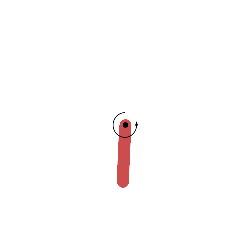

In [ ]:
#|hide
torch.manual_seed(0)

actor = Actor(3,1)
critic = Critic(3)

# Setup the Agent
agent = TRPOAgent(actor,max_steps=10000)

pipe = AdvantageGymTransformBlock(agent=agent,n=100,seed=None,include_images=True,critic=critic)(['Pendulum-v1'])
pipe = VSCodeTransformBlock()(pipe)

pipe2device(pipe,'cpu',debug=True)

L(pipe);
pipe.show(step=2)

## Learning

![](../../images/(Schulman%20et%20al.%2C%202017)%20%5BTRPO%5D%20Trust%20Region%20Policy%20Optimization%20Algorithm%201.png)

We start with finding the direction of conjugate gradients. 

In [ ]:
A = torch.tensor(
    [[3.,2.],[2.,6.]]
)
b = torch.tensor([[2.],[-8.]])

Ref [Shewchuk, 1994](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf), but
$A$ is the gradients of the model, and $b$ (typically the bias) is the loss.

The below function is pretty much example `B2` pg 50.

In [ ]:
#|export
def conjugate_gradients(
    # A function that takes the direction `d` and applies it to `A`.
    # The simplest example of this found would be:
    # `lambda d:A@d`
    Ad_f:Callable[[torch.Tensor],torch.Tensor],  
    # The bias or in TRPO's case the loss.
    b:torch.Tensor, 
    # Number of steps to go for assuming we are not less than `residual_tol`.
    nsteps:int, 
    # If the residual is less than this, then we have arrived at the local minimum.
    # Note that (Shewchuk, 1994) they mention that this should be E^2 * rdotr_0
    residual_tol=1e-10, 
    device="cpu"
):
    # The final direction to go in.
    x = torch.zeros(b.size()).to(device)
    # Would typically be b - Ax, however in TRPO's case this has already been 
    # done in the loss function.
    r = b.clone()
    # The first direction is the first residual.
    d = b.clone()
    rdotr = r.T @ r # \sigma_{new} pg50
    for i in range(nsteps):
        _Ad = Ad_f(d) # _Ad is also considered `q`
        # Determines the size / rate / step size of the direction
        alpha = rdotr / (d.T @ _Ad)

        x += alpha * d
        # [Shewchuk, 1994](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf) pg 49:
        #
        # The fast recursive formula for the residual is usually used, but once every 50 iterations, the exact residual
        # is recalculated to remove accumulated floating point error. Of course, the number 50 is arbitrary; for large
        # n \sqrt{n}, ©
        # might be appropriate.
        #
        # @josiah: This is kind of weird since we are using `Ad_f`. Maybe we can
        # have an optional param for A direction to do the residual reset?
        #
        # if nsteps > 50 and i % int(torch.sqrt(i)) == 0:
        #     r = b - Ax
        # else:
        r -= alpha * _Ad
        new_rdotr = r.T @ r
        beta = new_rdotr / rdotr
        d = r + beta * d
        rdotr = new_rdotr
        # Same as \sigma_{new} < E^2\sigma
        if rdotr < residual_tol:
            break
    return x

add_docs(
conjugate_gradients,
"""Conjugating Gradients builds on the idea of Conjugate Directions.

As noted in:
[Shewchuk, 1994](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf)

We want "everytime we take a step, we got it right the first time" pg 21. 

In otherwords, we have a model, and we have the gradients and the loss. Using the 
loss, what is the the smartest way to change/optimize the gradients?

`Conjugation` is the act of makeing the `parameter space / gradient space` easier to 
optimize over. In technical terms, we find `nsteps` directions to change the gradients
toward that are orthogonal to each other and to the `parameter space / gradient space`.

In otherwords, what is the direction that is most optimal, and what is the 
direction that if used to find `x` will reduce `Ax - b` to 0. 
"""
)

In [ ]:
conjugate_gradients(
    lambda d:A@d,
    b - A@torch.tensor([[50.],[50.]]),
    10
)

tensor([[-48.],
        [-52.]])

In [ ]:
#|export
def backtrack_line_search(
    # A Tensor of gradients or weights to optimize
    x:torch.Tensor,
    # The residual that when applied to `x`, hopefully optimizes it closer to the 
    # solution/ i.e. is orthogonal.
    r:torch.Tensor,
    # An error function that outputs the new error given the `x_new, where
    # `x_new` is passed as a param, and the error is returned as a float.
    # This error is compared, and expected greater than 0.
    error_f:Callable[[torch.Tensor],float],
    # The region of improvement we expect the see.
    expected_improvement_rate:torch.Tensor,
    # The minimal amount of improvement we expect to see.
    accaptance_tolerance:float=0.1,
    # The number of increments to attempt to improve `x`. 
    # Each "backtrack", the step size on the weights will be larger.
    n_max_backtracks:int=10
):
    e = error_f(x)
    for (n_back,alpha) in enumerate(.5**torch.range(n_max_backtracks)):
        x_new = x + alpha * r 
        e_new = error_f(x_new)
        improvement = e - e_new
        expected_improvement = expected_improvement_rate * alpha 
        ratio = improvement / expected_improvement
        if ratio.item() > accaptance_tolerance and improvement.item() > 0:
            return True, x_new
    return False, x

add_docs(
backtrack_line_search,
"""Backtrack line search attempts an update to a set of weights/gradients `x` `n_max_backtracks` times.

Each backtrack updates the weights/gradients a little more aggressively, and checks if `error_f`
decreases / improves. 
"""
)

In [ ]:
torch.manual_seed(0)
actor = Actor(4,2)
dist = actor(torch.randn(1,4))
old_log_prob_of_a = dist.log_prob(torch.randn(1,2))

In [ ]:
def test_loss(weights,s,a,r,actor,old_log_prob):
    if weights is not None:
        actor.state_dict(weights)
    dist = actor(s)
    log_prob = dist.log_prob(a)
    loss = -r * torch.exp(log_prob-old_log_prob) 
    return loss.mean()

test_loss(None,torch.randn(1,4),torch.randn(1,2),torch.randn(1,1),actor,old_log_prob_of_a)

tensor(1.0340, grad_fn=<MeanBackward0>)

In [ ]:
def pre_hessian_kl(
    model:Actor, # An Actor or any model that outputs a probability distribution
    x:torch.Tensor # Input into the model
):
    r"""
    Provides a KL conculation for the 2nd dirivative hessian to be calculated later.

    It is important to note that this function will return a tensor of 0, however
    the goal is to do autograd as opposed to doing anything with the value directly.

    The "confusing" part of the code can be found in [4]:

        "For two univariate normal distributions p and q the above simplifies to:"

    $D_{\text{KL}}\left({\mathcal {p}}\parallel {\mathcal {q}}\right)=\log {\frac {\sigma _{2}}{\sigma _{1}}}+{\frac {\sigma _{1}^{2}+(\mu _{1}-\mu _{2})^{2}}{2\sigma _{2}^{2}}}-{\frac {1}{2}}$

    Notes:
    - [1] https://github.com/ikostrikov/pytorch-trpo/issues/2
    - [2] [(Schulman et al., 2015) [TRPO] Trust Region Policy Optimization](https://arxiv.org/abs/1502.05477)
    
    Appendix C:
    
        One could alternatively use a generic method for calculating Hessian-vector products using 
        reverse mode automatic differentiation ((Wright & Nocedal, 1999), chapter 8), computing the 
        Hessian of DKL with respect to θ. This method would be slightly less efficient as it does 
        not exploit the fact that the second derivatives of μ(x) (i.e., the second term in Equation (57))
        can be ignored, but may be substantially easier to implement.

    - [3] http://rail.eecs.berkeley.edu/deeprlcoursesp17/docs/lec5.pdf
    - [4] https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#cite_note-27
    """
    dist = model(x)
    mu_v = dist.mean
    logstd_v = torch.log(dist.stddev)
    mu0_v = mu_v.detach()
    logstd0_v = logstd_v.detach()
    std_v = torch.exp(logstd_v)
    std0_v = std_v.detach()
    kl = logstd_v - logstd0_v + (std0_v ** 2 + (mu0_v - mu_v) ** 2) / (2.0 * std_v ** 2) - 0.5
    return kl.sum(1, keepdim=True)

In [ ]:
pre_hessian_kl(actor,torch.randn(1,4))

tensor([[0.]], grad_fn=<SumBackward1>)

In [ ]:
#|export
def forward_pass(
        weights:torch.Tensor,
        s:torch.Tensor,
        actor:Actor,
        damping:float=0.1
    ):
    kl = pre_hessian_kl(actor,s)
    kl = kl.mean()

    # Calculate the 1st derivative hessian
    grads = torch.autograd.grad(kl, actor.parameters(), create_graph=True)
    flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])

    kl_v = (flat_grad_kl * weights).sum()
    # Calculate the 2nd derivative hessian
    grads = torch.autograd.grad(kl_v, actor.parameters())
    flat_grad_grad_kl = torch.cat([grad.contiguous().view(-1) for grad in grads]).data

    return flat_grad_grad_kl + weights * damping

In [ ]:
forward_pass(
    get_flat_params_from(actor),    
    torch.randn(1,4),
    actor
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4 and 3x400)

In [ ]:
from torch.optim import AdamW,Adam
from fastrl.learner.core import LearnerBase,LearnerHead
from fastrl.loggers.core import LoggerBasePassThrough,BatchCollector,EpocherCollector,RollingTerminatedRewardCollector,EpisodeCollector

from fastrl.agents.ddpg import BasicOptStepper

In [ ]:
from copy import deepcopy

In [ ]:
#|export
class CriticLossProcessor(dp.iter.IterDataPipe):
    debug:bool=False

    def __init__(self,
            source_datapipe:DataPipe, # The parent datapipe that should yield step types
            critic:Critic, # The critic to optimize
            # The loss function to use
            loss:nn.Module=nn.MSELoss,
            # The discount factor of `q`. Typically does not need to be changed,
            # and determines the importants of earlier state qs verses later state qs
            discount:float=0.99,
            # If the environment has `nsteps>1`, it is recommended to change this
            # param to reflect that so the reward estimates are more accurate.
            nsteps:int=1
        ):
        self.source_datapipe = source_datapipe
        self.critic = critic
        self.loss = loss()
        self.discount = discount
        self.nsteps = nsteps
        self.device = None

    def to(self,*args,**kwargs):
        self.critic.to(**kwargs)
        self.device = kwargs.get('device',None)

    def __iter__(self) -> Union[Dict[Literal['loss'],torch.Tensor],SimpleStep]:
        for batch in self.source_datapipe:
            # Slow needs better strategy
            with torch.no_grad():
                batch = batch.clone()

            batch.to(self.device)

            traj_adv_v = (batch.advantage - torch.mean(batch.advantage)) / torch.std(batch.advantage)

            self.critic.zero_grad()
            pred = self.critic(batch.state)
            yield {'loss':self.loss(pred,traj_adv_v)}
            yield batch

In [ ]:
from fastrl.agents.ddpg import LossCollector,BasicOptStepper,StepBatcher

In [ ]:
#|export
def TRPOLearner(
    # The actor model to use
    actor:Actor,
    # The critic model to use
    critic:Critic,
    # A list of dls, where index=0 is the training dl.
    dls:List[DataPipeOrDataLoader],
    # Optional logger bases to log training/validation data to.
    logger_bases:Optional[List[LoggerBase]]=None,
    # The learning rate for the actor. Expected to learn slower than the critic
    actor_lr:float=1e-3,
    # The optimizer for the actor
    actor_opt:torch.optim.Optimizer=Adam,
    # The learning rate for the critic. Expected to learn faster than the actor
    critic_lr:float=1e-2,
    # The optimizer for the critic
    # Note that weight decay doesnt seem to be great for 
    # Pendulum, so we use regular Adam, which has the decay rate
    # set to 0. (Lillicrap et al., 2016) would instead use AdamW
    critic_opt:torch.optim.Optimizer=Adam,
    # Reference: ExperienceReplay docs 
    bs:int=128,
    # Reference: ExperienceReplay docs
    max_sz:int=10000,
    # Reference: GymStepper docs
    nsteps:int=1,
    # The device for the entire pipeline to use. Will move the agent, dls, 
    # and learner to that device.
    device:torch.device=None,
    # Number of batches per epoch
    batches:int=None,
    # Any augmentations to the learner
    dp_augmentation_fns:Optional[List[DataPipeAugmentationFn]]=None,
    # Debug mode will output device moves
    debug:bool=False
) -> LearnerHead:
    learner = LearnerBase(actor,dls,batches=batches)
    learner = LoggerBasePassThrough(learner,logger_bases)
    learner = BatchCollector(learner,batch_on_pipe=LearnerBase)
    learner = EpocherCollector(learner)
    for logger_base in L(logger_bases): learner = logger_base.connect_source_datapipe(learner)
    if logger_bases: 
        learner = RollingTerminatedRewardCollector(learner)
        learner = EpisodeCollector(learner)
    learner = StepBatcher(learner)
    learner = CriticLossProcessor(learner,critic=critic)
    learner = LossCollector(learner,header='critic-loss')
    learner = BasicOptStepper(learner,critic,critic_lr,opt=critic_opt,filter=True,do_zero_grad=False)
    learner = LearnerHead(learner)
    
    learner = apply_dp_augmentation_fns(learner,dp_augmentation_fns)
    pipe2device(learner,device,debug=debug)
    for dl in dls: pipe2device(dl.datapipe,device,debug=debug)
    
    return learner

TRPOLearner.__doc__=""""""

In [ ]:
from fastrl.loggers.vscode_visualizers import VSCodeTransformBlock
from fastrl.loggers.jupyter_visualizers import ProgressBarLogger

In [ ]:
#|eval:false
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
actor = Actor(3,1)
critic = Critic(3)

# Setup the Agent
agent = TRPOAgent(actor,[logger_base])

# Setup the DataBlock
block = DataBlock(
    (AdvantageGymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True,critic=critic,bs=64)), 
    (AdvantageGymTransformBlock(agent=agent,n=400,nsteps=2,nskips=2,firstlast=True,include_images=True,critic=critic,bs=64),VSCodeTransformBlock())
)
dls = L(block.dataloaders(['Pendulum-v1']*1))
# Setup the Learner
learner = TRPOLearner(actor,critic,dls,logger_bases=[logger_base],
                      bs=128,max_sz=20_000,nsteps=2,
                      batches=1000)
# learner.fit(1)
learner.fit(1)

critic-loss,episode,rolling_reward,epoch,batch
0.9129425,6,-1247.629675,0,1001


In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()